Sentiment Analysis for predicting short-term price direction using r/WallstreetBet

In [ ]:
!pip install lxml_html_clean
!pip install newspaper3k
!pip install vaderSentiment
import pandas as pd
import re
from datetime import datetime
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 50.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.1/211.1 kB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.4/107.4 kB 9.0 MB/s eta 0:00:00
  Created wheel for tinysegmenter: filename=tinysegmenter-0.3-py3-none-any.whl size=13540 sha256=63b4db10ad3dbf05ed21af769a425e891250aebaf2ef20418bde06fae37adcf8
  Stored in directory: /root/.cache/pip/wheels/fc/ab/f8/cce3a9ae6d828bd346be695f7ff54612cd22b7cbd7208d68f3
  Created wheel for feedfinder2: filename=feedfinder2-0.0.4-py3-none-any.whl size=3341 sha256=31c585bc775719d26c04419290d162294bc292cdf8366b6bf1c9a2f8823fc5e1
  Stored in directory: /root/.cache/pip/wheels/80/d5/72/9cd9eccc819636436c6a6e59c22a0fb1ec

In [ ]:
# Ensure you have a kaggle.json
!pip install kaggle
import os
os.makedirs('/root/.kaggle', exist_ok=True)
!mv kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

# 2. Download datasets
#Reddit dataset 1
!kaggle datasets download -d gpreda/reddit-wallstreetsbets-posts
!unzip -o reddit-wallstreetsbets-posts.zip
#Reddit dataset 2
!kaggle datasets download -d gpreda/wallstreetbets-2022
!unzip -o wallstreetbets-2022.zip


Dataset URL: https://www.kaggle.com/datasets/gpreda/reddit-wallstreetsbets-posts
License(s): CC0-1.0
Archive:  reddit-wallstreetsbets-posts.zip
  inflating: reddit_wsb.csv          
Dataset URL: https://www.kaggle.com/datasets/gpreda/wallstreetbets-2022
License(s): CC0-1.0
Archive:  wallstreetbets-2022.zip
  inflating: wallstreetbets_2022.csv  


Importing and cleaning 2021 WSB Dataset

In [ ]:
# --- Load Reddit posts from reddit-wallstreetbets-posts (dataset 1) ---
reddit1 = pd.read_csv('reddit_wsb.csv', parse_dates=['timestamp'])
print("Reddit WSB_2021 columns:", reddit1.columns)

# Filter for posts about NVIDIA
pattern = r'\bNVDA\b|\bNvidia\b'
reddit1 = reddit1[reddit1['title'].str.contains(pattern, case=False, na=False, regex=True)].copy()

# Rename columns for standardization
reddit1 = reddit1.rename(columns={'timestamp': 'date', 'title': 'text'})[['date', 'text']]
reddit1['date'] = pd.to_datetime(reddit1['date']).dt.date
reddit1['source'] = 'reddit'

print(f"Reddit 2021 NVIDIA posts: {len(reddit1)}")
print(reddit1.head(3))

Reddit WSB_2021 columns: Index(['title', 'score', 'id', 'url', 'comms_num', 'created', 'body',
       'timestamp'],
      dtype='object')
Reddit 2021 NVIDIA posts: 60
             date                                               text  source
2680   2021-01-29  In terms of opportunities and OTM Calls I real...  reddit
32887  2021-02-12                  8th grade research project: $NVDA  reddit
33380  2021-02-17                       Ramblings of a Retard (NVDA)  reddit


Importing and cleaning 2022 WSB Dataset

In [ ]:
# --- Load Reddit posts from wallstreetbets-2022 (dataset 2) ---
reddit2 = pd.read_csv('wallstreetbets_2022.csv', parse_dates=['timestamp'], low_memory=False) #low_memory reads the whole pandas before guessing dtypes, titles has different dtypes
print("Reddit WSB_2022 columns:", reddit2.columns)

reddit2 = reddit2[reddit2['title'].str.contains(pattern, case=False, na=False, regex=True)].copy()

reddit2 = reddit2.rename(columns={'timestamp': 'date', 'title': 'text'})[['date', 'text']]
reddit2['date'] = pd.to_datetime(reddit2['date']).dt.date
reddit2['source'] = 'reddit'

print(f"Reddit 2022 NVIDIA posts: {len(reddit2)}")
print(reddit2.head(3))

Reddit WSB_2022 columns: Index(['title', 'score', 'id', 'url', 'comms_num', 'created', 'body',
       'timestamp'],
      dtype='object')
Reddit 2022 NVIDIA posts: 2996
            date                                               text  source
3472  2022-04-02  I’m not letting Frederick win. All in NVDA 7DT...  reddit
5591  2022-04-04            NVDA in trouble by the end of the year?  reddit
7621  2022-04-06      Roku competition AMZN firestick Nvidia Shield  reddit


Combine the datasets

In [ ]:
#Combine the two into one DataFrame
wsb_all = pd.concat([reddit1, reddit2], ignore_index=True)

#(Optional but good practice) Remove duplicates
wsb_all = wsb_all.drop_duplicates(subset=['date', 'text'])

#Sort by date (not strictly necessary, but helps later)
wsb_all = wsb_all.sort_values('date').reset_index(drop=True)

print(f"Total unique NVDA/NVIDIA posts in combined WSB: {len(wsb_all)}")
print(wsb_all.head())

Total unique NVDA/NVIDIA posts in combined WSB: 3048
         date                                               text  source
0  2021-01-29  In terms of opportunities and OTM Calls I real...  reddit
1  2021-02-12                  8th grade research project: $NVDA  reddit
2  2021-02-16  $NVDA - $400K in 19 days - Listen now. Your ey...  reddit
3  2021-02-17                       Ramblings of a Retard (NVDA)  reddit
4  2021-02-23   Nvidia RTX 3060 Pricing Skyrockets Before Launch  reddit


Sentiment Scoring / Meme and phrases

In [ ]:
# Initialize VADER analyzer
analyzer = SentimentIntensityAnalyzer()

# 1. Compute the VADER sentiment score
wsb_all['vader'] = wsb_all['text'].apply(lambda t: analyzer.polarity_scores(str(t))['compound'])

# 2. Meme/Emoji/Hype scoring
def detect_hype(text):
    hype_emojis = ['🚀', '💎', '🔥', '🙌', '📈', '💰']
    hype_phrases = ['to the moon', 'diamond hands', 'hold', 'pump', 'ape', 'yolo']
    emoji_score = sum(e in str(text) for e in hype_emojis)
    phrase_score = sum(p in str(text).lower() for p in hype_phrases)
    return emoji_score + phrase_score

wsb_all['hype'] = wsb_all['text'].apply(detect_hype)

# 3. Create a hybrid sentiment score (tune weights as you like!) #Need to find better weight value
wsb_all['sentiment'] = 0.8 * wsb_all['vader'] + 0.2 * wsb_all['hype']

# Preview
print(wsb_all[['date', 'text', 'vader', 'hype', 'sentiment']].head(12))


          date                                               text   vader  \
0   2021-01-29  In terms of opportunities and OTM Calls I real...  0.7574   
1   2021-02-12                  8th grade research project: $NVDA  0.0000   
2   2021-02-16  $NVDA - $400K in 19 days - Listen now. Your ey...  0.0000   
3   2021-02-17                       Ramblings of a Retard (NVDA) -0.5267   
4   2021-02-23   Nvidia RTX 3060 Pricing Skyrockets Before Launch  0.0000   
5   2021-02-23                                  $NVDA Long Thesis  0.0000   
6   2021-03-04  Just a $110k loss in less than a month due to ...  0.0772   
7   2021-03-04  Just a $110k loss in less than a month due to ...  0.0772   
8   2021-03-09          Nvidia YOLO + GME put over the past month  0.4278   
9   2021-03-20  Loss Porn Quadruple Witching day UPDATE 270k t... -0.3182   
10  2021-04-10  Note how Apple, AMD, and NVIDIA are all not on...  0.7876   
11  2021-04-13  AMD down -5% on NVDA’s DPU. Long 10 AMD $80 7/...  0.0000   

Virality

In [ ]:
# Reload your raw files with virality columns
raw1 = pd.read_csv('reddit_wsb.csv', parse_dates=['timestamp'])
raw2 = pd.read_csv('wallstreetbets_2022.csv', parse_dates=['timestamp'], low_memory=False)
pattern = r'\bNVDA\b|\bNVIDIA\b'

# Filter and prepare just like you did previously:
raw1 = raw1[raw1['title'].str.contains(pattern, case=False, na=False, regex=True)].copy()
raw2 = raw2[raw2['title'].str.contains(pattern, case=False, na=False, regex=True)].copy()
raw1['date'] = pd.to_datetime(raw1['timestamp']).dt.date
raw2['date'] = pd.to_datetime(raw2['timestamp']).dt.date
raw1 = raw1.rename(columns={'title': 'text'})
raw2 = raw2.rename(columns={'title': 'text'})
raw1 = raw1[['date','text','score','comms_num']]
raw2 = raw2[['date','text','score','comms_num']]

# Merge virality info into your main dataframe
all_virality = pd.concat([raw1, raw2], ignore_index=True)
wsb_all = pd.merge(wsb_all, all_virality, on=['date', 'text'], how='left')

# Sanitize columns: force to numbers
for col in ['score', 'comms_num']:
    wsb_all[col] = pd.to_numeric(wsb_all[col], errors='coerce').fillna(0)

In [ ]:
# Aggregate: simple impact = sentiment * (upvotes + comments)
wsb_all['virality'] = wsb_all['score'] + wsb_all['comms_num']
wsb_all['impact'] = wsb_all['sentiment'] * wsb_all['virality']
print(wsb_all[['date','text','sentiment','virality','impact']].sort_values('impact', ascending=False).head(10))

            date                                               text  \
1190  2024-03-02                   70k > 1.1 Mil Thank god For NVDA   
2632  2024-10-16  Nvidia is worth 11.7% of the US GDP now. At th...   
1126  2024-02-23          $1.6m gain on NVDA call spread, +$18m YTD   
916   2024-02-12  Nvidia Is Now More Valuable Than Amazon And Go...   
210   2022-12-28  What a ride this month! Mostly thanks to NVDA,...   
91    2022-07-20                      Nancy Says: NVDA To The Moon!   
2904  2025-01-28          Not buying the NVDA dip yesterday be like   
2183  2024-07-09  Using my parents’ down payment money, thank go...   
1898  2024-06-10  Nvidia is responsible for 36% of the TOTAL mar...   
511   2023-07-15  Saw this and thought of you Nvidia bros, assum...   

      sentiment  virality      impact  
1190    0.44592   16466.0  7342.51872  
2632    0.33720   21692.0  7314.54240  
1126    0.42136   13507.0  5691.30952  
916     0.52392    9600.0  5029.63200  
210     0.39408   

In [ ]:
# Aggregate per day - get post volume, mean/max/sum sentiment, mean/max/sum impact
wsb_daily = wsb_all.groupby('date').agg(
    n_posts    = ('text', 'count'),
    mean_sent  = ('sentiment', 'mean'),
    sum_sent   = ('sentiment', 'sum'),
    mean_hype  = ('hype', 'mean'),
    mean_vir   = ('virality', 'mean'),
    mean_imp   = ('impact', 'mean'),
    sum_imp    = ('impact', 'sum')
).reset_index()
print(wsb_daily.tail())

           date  n_posts  mean_sent  sum_sent  mean_hype  mean_vir  \
719  2025-03-20        1    0.18104   0.18104        0.0    1371.0   
720  2025-03-22        1    0.64592   0.64592        1.0    2716.0   
721  2025-03-24        2    0.27112   0.54224        0.5     279.5   
722  2025-03-26        2   -0.13948  -0.27896        0.0     177.0   
723  2025-03-27        2    0.02064   0.04128        0.0     205.0   

       mean_imp     sum_imp  
719   248.20584   248.20584  
720  1754.31872  1754.31872  
721   100.31440   200.62880  
722   -40.36196   -80.72392  
723     8.09088    16.18176  


In [ ]:
import yfinance as yf

start_date = str(wsb_daily['date'].min())
end_date   = str(wsb_daily['date'].max())

nvda = yf.download('NVDA', start=start_date, end=end_date)
nvda['date'] = nvda.index.date
nvdaa = nvda[['date','Open','High','Low','Close','Volume']]
nvda.reset_index(drop=True, inplace=True)

vix = yf.download('^VIX', start=start_date, end=end_date)
vix['date'] = vix.index.date
vix = vix[['date','Close']]
vix.rename(columns={'Close':'VIX_Close'}, inplace=True)
vix.reset_index(drop=True, inplace=True)


# Make sure 'date' is a column, not the index, in all frames to prevent MergeError
for df_ in [nvda, wsb_daily, vix]:
    df_.reset_index(inplace=True)  # keep (don't drop!) any column that was index

# Some aggregations produce tuple column names; flatten them:
def flatten_columns(df):
    df.columns = [c[0] if isinstance(c, tuple) else c for c in df.columns]
    return df

nvda = flatten_columns(nvda)
wsb_daily = flatten_columns(wsb_daily)
vix = flatten_columns(vix)

# Diagnostic check
for name, df_ in zip(['nvda', 'wsb_daily', 'vix'], [nvda, wsb_daily, vix]):
    print(f"{name}: columns={df_.columns.tolist()} | index={df_.index}")

assert 'date' in nvda.columns
assert 'date' in wsb_daily.columns
assert 'date' in vix.columns

# Now: safe to merge
df = nvda.merge(wsb_daily, on='date', how='left').merge(vix, on='date', how='left')
df.fillna(0, inplace=True)
df['target_return'] = df['Close'].pct_change().shift(-1)  # Next-day return
df = df.dropna(subset=['target_return'])

df = nvda.merge(wsb_daily, on='date', how='left').merge(vix, on='date', how='left')
df.fillna(0, inplace=True)

df['target_return'] = df['Close'].pct_change().shift(-1)  # Next-day return
df = df.dropna(subset=['target_return'])


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

nvda: columns=['index', 'Close', 'High', 'Low', 'Open', 'Volume', 'date'] | index=RangeIndex(start=0, stop=1044, step=1)
wsb_daily: columns=['index', 'date', 'n_posts', 'mean_sent', 'sum_sent', 'mean_hype', 'mean_vir', 'mean_imp', 'sum_imp'] | index=RangeIndex(start=0, stop=724, step=1)
vix: columns=['index', 'date', 'VIX_Close'] | index=RangeIndex(start=0, stop=1044, step=1)


In [ ]:
from sklearn.preprocessing import StandardScaler
import torch
import numpy as np

# ----- Feature columns -----
feature_cols = [
    'Open','High','Low','Close','Volume',
    'mean_sent','sum_sent','mean_hype','mean_vir','mean_imp','sum_imp','n_posts','VIX_Close'
]

# Standardize features for better LSTM performance
scaler = StandardScaler()
df[feature_cols] = scaler.fit_transform(df[feature_cols])

# ----- Build rolling sequences (lookback window of 5 days)
def build_sequences(df, window=5):
    X, y = [], []
    for i in range(len(df) - window):
        X.append(df[feature_cols].iloc[i:i+window].values)
        y.append(df['target_return'].iloc[i+window])
    return np.array(X), np.array(y)

X, y = build_sequences(df, window=5)
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32).unsqueeze(-1)

print("X shape:", X.shape, "y shape:", y.shape)
# Should be (n_samples, window_size, n_features), (n_samples, 1)

X shape: torch.Size([1038, 5, 13]) y shape: torch.Size([1038, 1])


In [ ]:
# Simple 80/20 split (time order preserved for time-series)
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [ ]:
import torch.nn as nn

class LSTMNet(nn.Module):
    def __init__(self, n_features, hidden=32):
        super().__init__()
        self.lstm = nn.LSTM(n_features, hidden, batch_first=True)
        self.fc = nn.Linear(hidden, 1)
    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])

model = LSTMNet(X.shape[2], hidden=32)  # 32 hidden units can be tuned
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.MSELoss()

In [ ]:
n_epochs = 70

for epoch in range(n_epochs):
    model.train()
    optimizer.zero_grad()
    y_pred = model(X_train)
    loss = loss_fn(y_pred, y_train)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0 or epoch == n_epochs-1:
        with torch.no_grad():
            val_loss = loss_fn(model(X_test), y_test)
        print(f"Epoch {epoch:3d}: Train Loss={loss.item():.6f} | Val Loss={val_loss.item():.6f}")

Epoch   0: Train Loss=0.005367 | Val Loss=0.038254
Epoch  10: Train Loss=0.002395 | Val Loss=0.011569
Epoch  20: Train Loss=0.001228 | Val Loss=0.003397
Epoch  30: Train Loss=0.001144 | Val Loss=0.004298
Epoch  40: Train Loss=0.001098 | Val Loss=0.004002
Epoch  50: Train Loss=0.001072 | Val Loss=0.002993
Epoch  60: Train Loss=0.001057 | Val Loss=0.003196
Epoch  69: Train Loss=0.001043 | Val Loss=0.002849


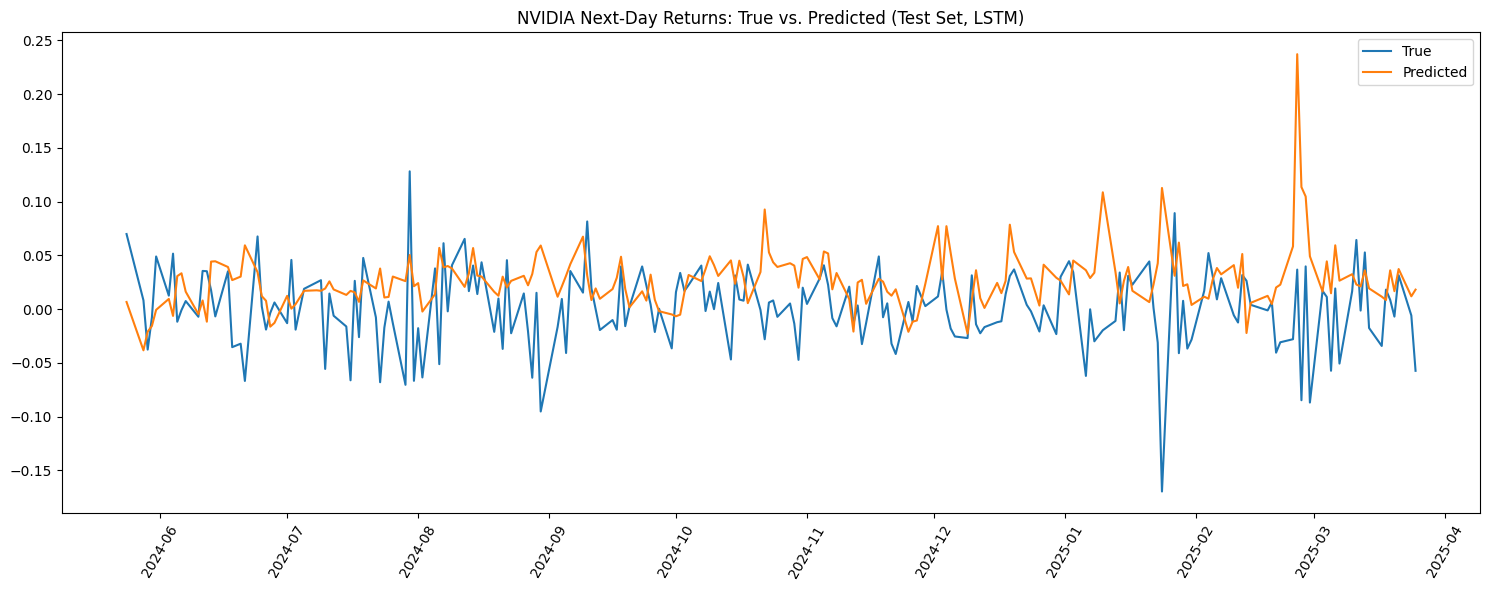

Test R2: -1.199, Test RMSE: 0.05337


In [ ]:
import matplotlib.pyplot as plt

model.eval()
with torch.no_grad():
    y_pred_train = model(X_train).flatten().numpy()
    y_pred_test = model(X_test).flatten().numpy()
    y_test_np = y_test.flatten().numpy()

dates_test = df['date'].values[5+split:5+split+len(y_pred_test)]

plt.figure(figsize=(15,6))
plt.plot(dates_test, y_test_np, label='True')
plt.plot(dates_test, y_pred_test, label='Predicted')
plt.legend()
plt.title('NVIDIA Next-Day Returns: True vs. Predicted (Test Set, LSTM)')
plt.xticks(rotation=60)
plt.tight_layout()
plt.show()

# Optionally, calculate simple performance metrics:
from sklearn.metrics import r2_score, mean_squared_error
print(f"Test R2: {r2_score(y_test_np, y_pred_test):.3f}, Test RMSE: {np.sqrt(mean_squared_error(y_test_np, y_pred_test)):.5f}")

In [ ]:
print(df.iloc[5+split:5+split+len(y_pred_test)][['date','sum_imp','mean_sent','target_return']].sort_values('sum_imp', ascending=False).head())

            date    sum_imp  mean_sent  target_return
934   2024-10-16  10.735365   2.010816       0.008915
845   2024-06-10   5.883126   0.773212      -0.007144
1003  2025-01-28   5.450611   0.604364      -0.041011
864   2024-07-09   5.413958   1.148020       0.026869
835   2024-05-24   5.028352   0.632987       0.069804


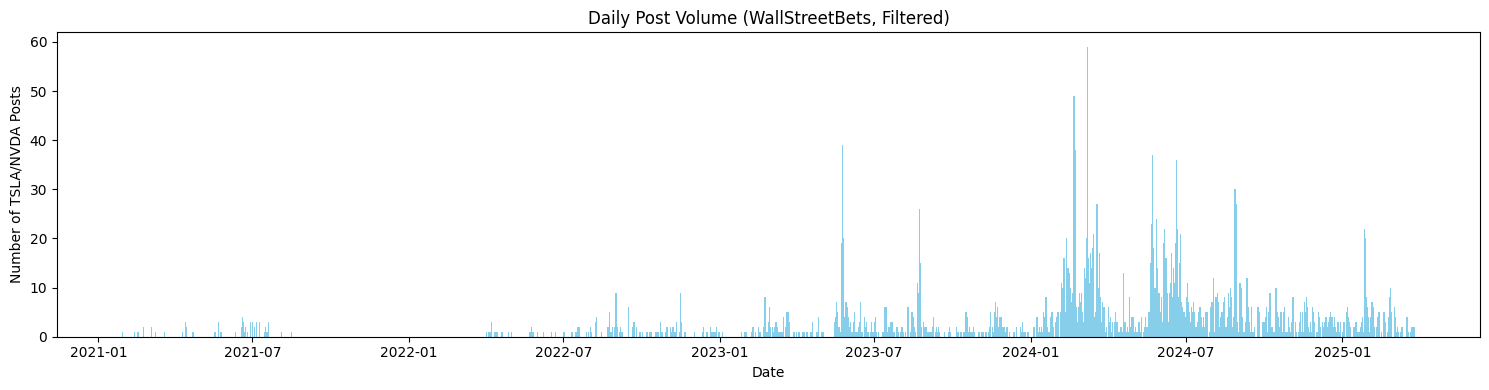

In [ ]:
wsb_daily['date_dt'] = pd.to_datetime(wsb_daily['date'])
plt.figure(figsize=(15,4))
plt.bar(wsb_daily['date_dt'], wsb_daily['n_posts'], width=1.5, color='skyblue')
plt.xlabel('Date')
plt.ylabel('Number of TSLA/NVDA Posts')
plt.title('Daily Post Volume (WallStreetBets, Filtered)')
plt.tight_layout()
plt.show()

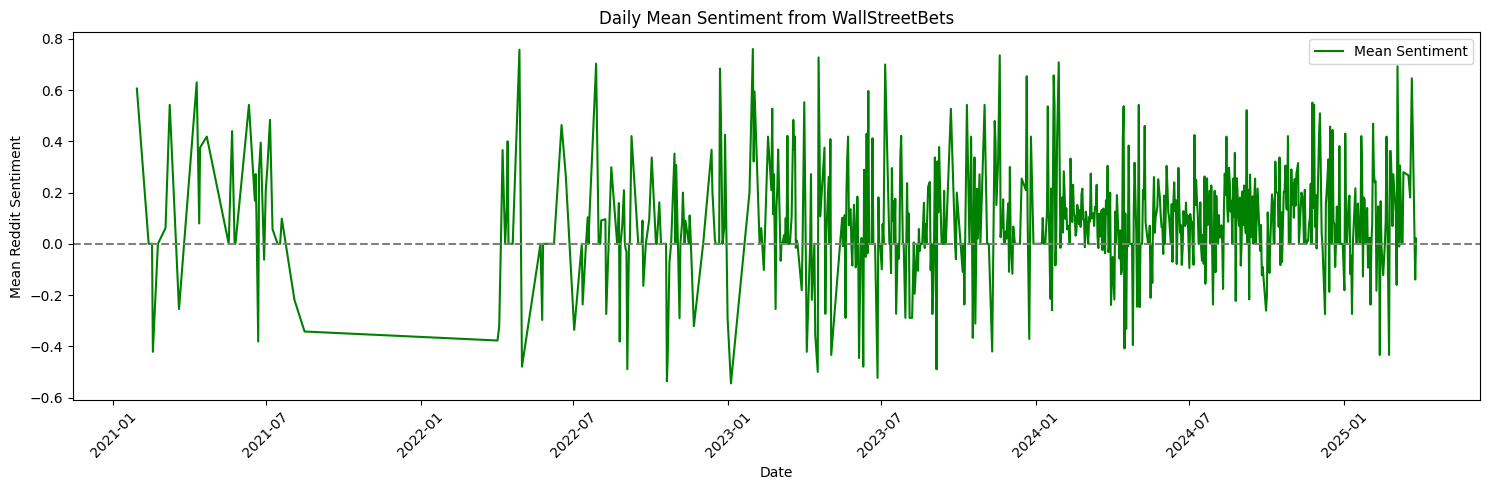

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,5))
plt.plot(wsb_daily['date'], wsb_daily['mean_sent'], label='Mean Sentiment', color='green')
plt.axhline(0, color='gray', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Mean Reddit Sentiment')
plt.title('Daily Mean Sentiment from WallStreetBets')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

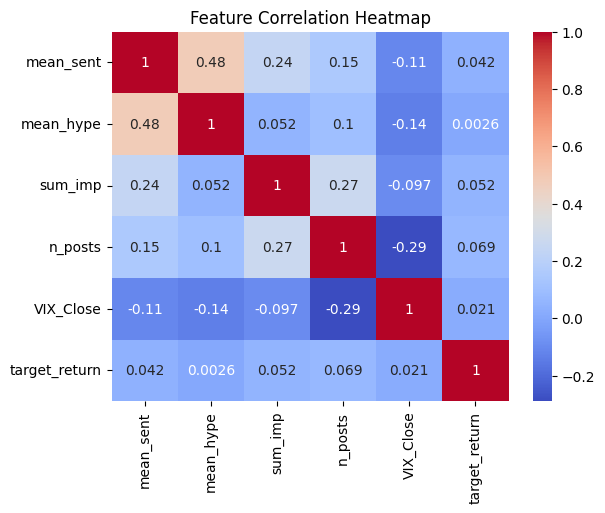

In [ ]:
import seaborn as sns
features_to_show = ['mean_sent', 'mean_hype', 'sum_imp', 'n_posts', 'VIX_Close', 'target_return']
corr_matrix = df[features_to_show].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()